In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine
import warnings
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

lifeexpectancy_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [2]:
# What does the data look like?
lifeexpectancy_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [3]:
# What types of data are in the df?
lifeexpectancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

In [4]:
# how many nulls in the set?
lifeexpectancy_df.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

In [5]:
# separate the columns that have nulls for imputation
cols_with_null = []
for col in lifeexpectancy_df.columns:
    if lifeexpectancy_df[col].isnull().sum() > 0:
        cols_with_null.append(col)
print(cols_with_null)

['Life expectancy ', 'Adult Mortality', 'Alcohol', 'Hepatitis B', ' BMI ', 'Polio', 'Total expenditure', 'Diphtheria ', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling']


In [6]:
# make a copy in case something bad happens!
le2 = lifeexpectancy_df.copy()

# imputation will be done by country
countries = lifeexpectancy_df["Country"].unique()

# imputation using each country's mean value
for col in cols_with_null:
    for c in countries:
        le2.loc[le2["Country"] == c, col] = le2.loc[le2["Country"] == c, col].fillna(le2[le2["Country"] == c][col].mean())

In [7]:
# how much effect did imputation have?
for col in cols_with_null:
    print("Statistics for columns: {}".format(col))
    print(pd.concat([lifeexpectancy_df[col], le2[col]], axis=1).describe())

Statistics for columns: Life expectancy 
       Life expectancy   Life expectancy 
count       2928.000000       2928.000000
mean          69.224932         69.224932
std            9.523867          9.523867
min           36.300000         36.300000
25%           63.100000         63.100000
50%           72.100000         72.100000
75%           75.700000         75.700000
max           89.000000         89.000000
Statistics for columns: Adult Mortality
       Adult Mortality  Adult Mortality
count      2928.000000      2928.000000
mean        164.796448       164.796448
std         124.292079       124.292079
min           1.000000         1.000000
25%          74.000000        74.000000
50%         144.000000       144.000000
75%         228.000000       228.000000
max         723.000000       723.000000
Statistics for columns: Alcohol
           Alcohol      Alcohol
count  2744.000000  2921.000000
mean      4.602861     4.600849
std       4.052413     4.038985
min       0.010000   

In [8]:
le2.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                             17
percentage expenditure               0
Hepatitis B                        144
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                                0
Total expenditure                   32
Diphtheria                           0
 HIV/AIDS                            0
GDP                                405
Population                         648
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

Fewer nulls than before, although some remain due to certain country/parameter combos that have no data, therefore no mean can be computed for imputation. Let's look over the histograms now and see which data have outliers that need addressing.

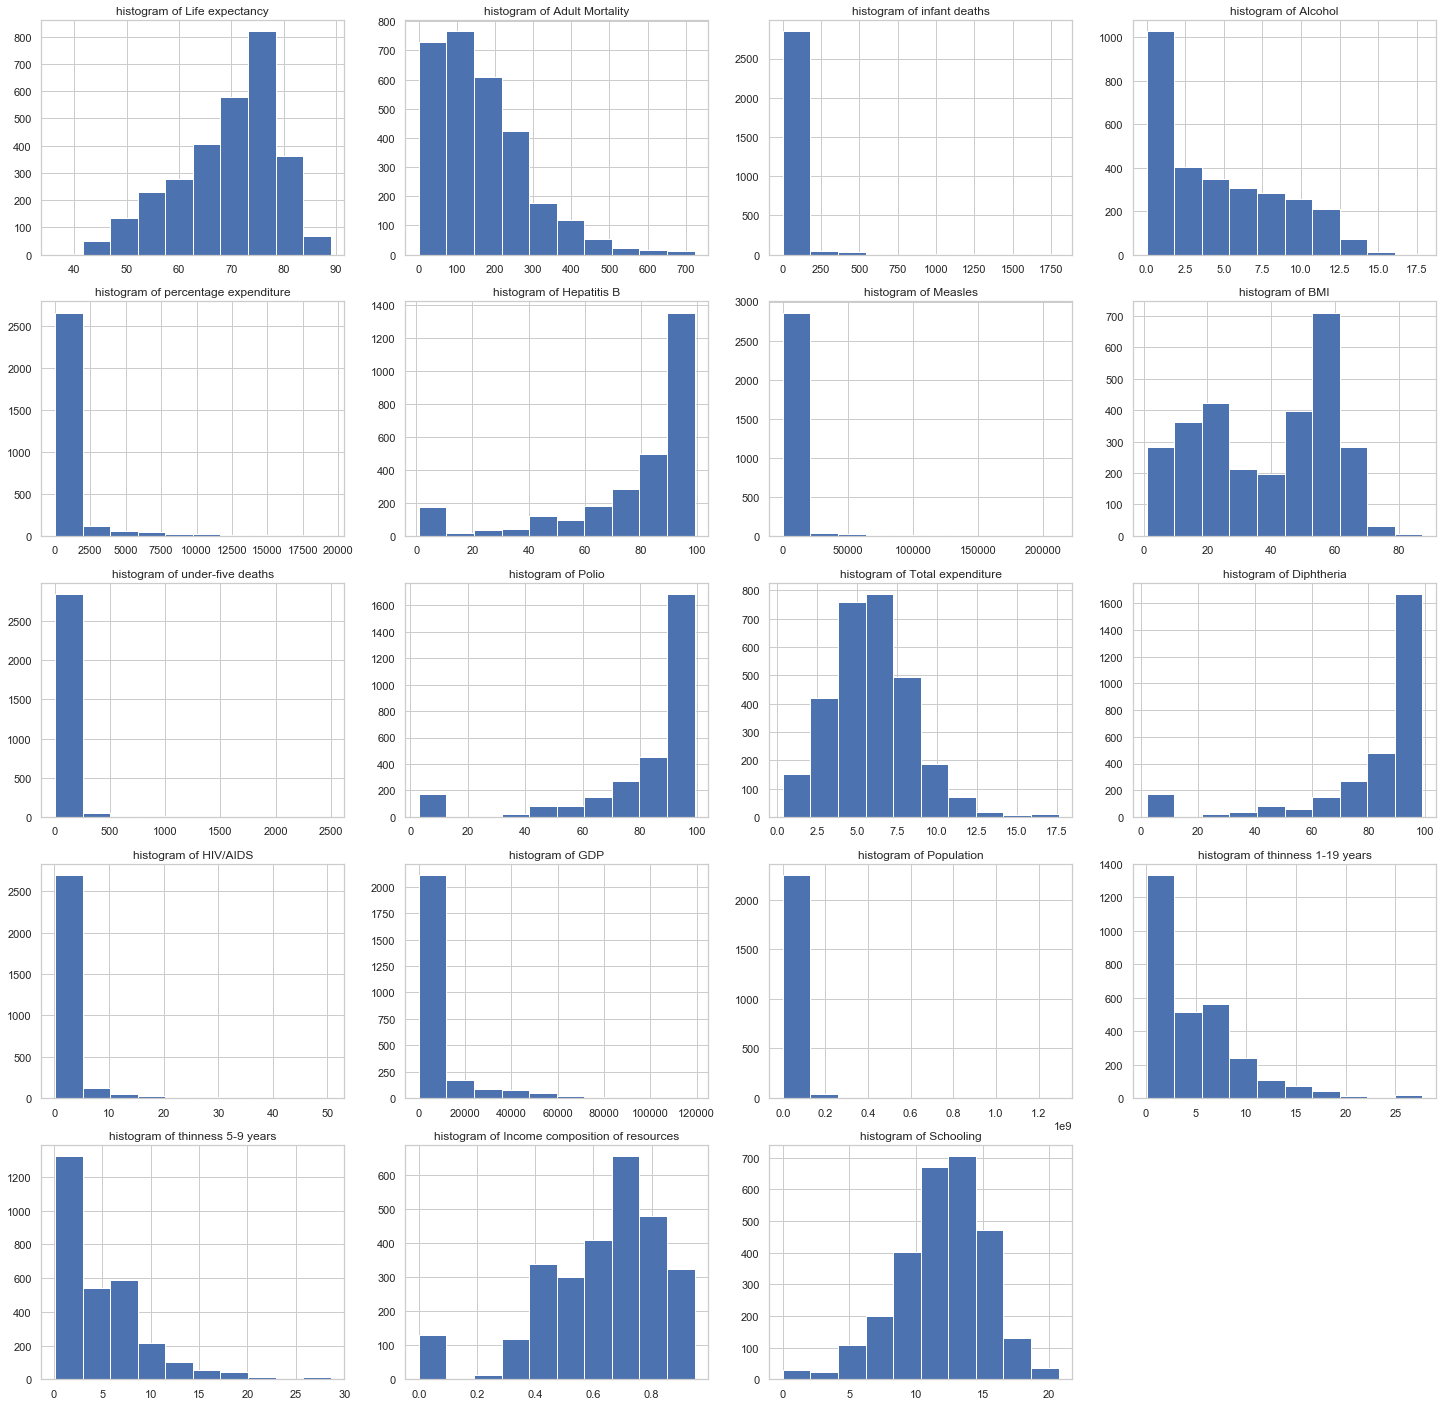

In [9]:
plt.figure(figsize=(25,25))

plt.subplot(5, 4, 1)
plt.hist(le2["Life expectancy "])
plt.title("histogram of Life expectancy")

plt.subplot(5, 4, 2)
plt.hist(le2["Adult Mortality"])
plt.title("histogram of Adult Mortality")

plt.subplot(5, 4, 3)
plt.hist(le2["infant deaths"])
plt.title("histogram of infant deaths")

plt.subplot(5, 4, 4)
plt.hist(le2["Alcohol"])
plt.title("histogram of Alcohol")

plt.subplot(5, 4, 5)
plt.hist(le2["percentage expenditure"])
plt.title("histogram of percentage expenditure")

plt.subplot(5, 4, 6)
plt.hist(le2["Hepatitis B"])
plt.title("histogram of Hepatitis B")

plt.subplot(5, 4, 7)
plt.hist(le2["Measles "])
plt.title("histogram of Measles")

plt.subplot(5, 4, 8)
plt.hist(le2[" BMI "])
plt.title("histogram of BMI")

plt.subplot(5, 4, 9)
plt.hist(le2["under-five deaths "])
plt.title("histogram of under-five deaths")

plt.subplot(5, 4, 10)
plt.hist(le2["Polio"])
plt.title("histogram of Polio")

plt.subplot(5, 4, 11)
plt.hist(le2["Total expenditure"])
plt.title("histogram of Total expenditure")

plt.subplot(5, 4, 12)
plt.hist(le2["Diphtheria "])
plt.title("histogram of Diphtheria")

plt.subplot(5, 4, 13)
plt.hist(le2[" HIV/AIDS"])
plt.title("histogram of HIV/AIDS")

plt.subplot(5, 4, 14)
plt.hist(le2["GDP"])
plt.title("histogram of GDP")

plt.subplot(5, 4, 15)
plt.hist(le2["Population"])
plt.title("histogram of Population")

plt.subplot(5, 4, 16)
plt.hist(le2[" thinness  1-19 years"])
plt.title("histogram of thinness 1-19 years")

plt.subplot(5, 4, 17)
plt.hist(le2[" thinness 5-9 years"])
plt.title("histogram of thinness 5-9 years")

plt.subplot(5, 4, 18)
plt.hist(le2["Income composition of resources"])
plt.title("histogram of Income composition of resources")

plt.subplot(5, 4, 19)
plt.hist(le2["Schooling"])
plt.title("histogram of Schooling")

plt.show()

Many of the parameters look to be distributed approximately normally, but let's fix the remainder and store everything in a new df.

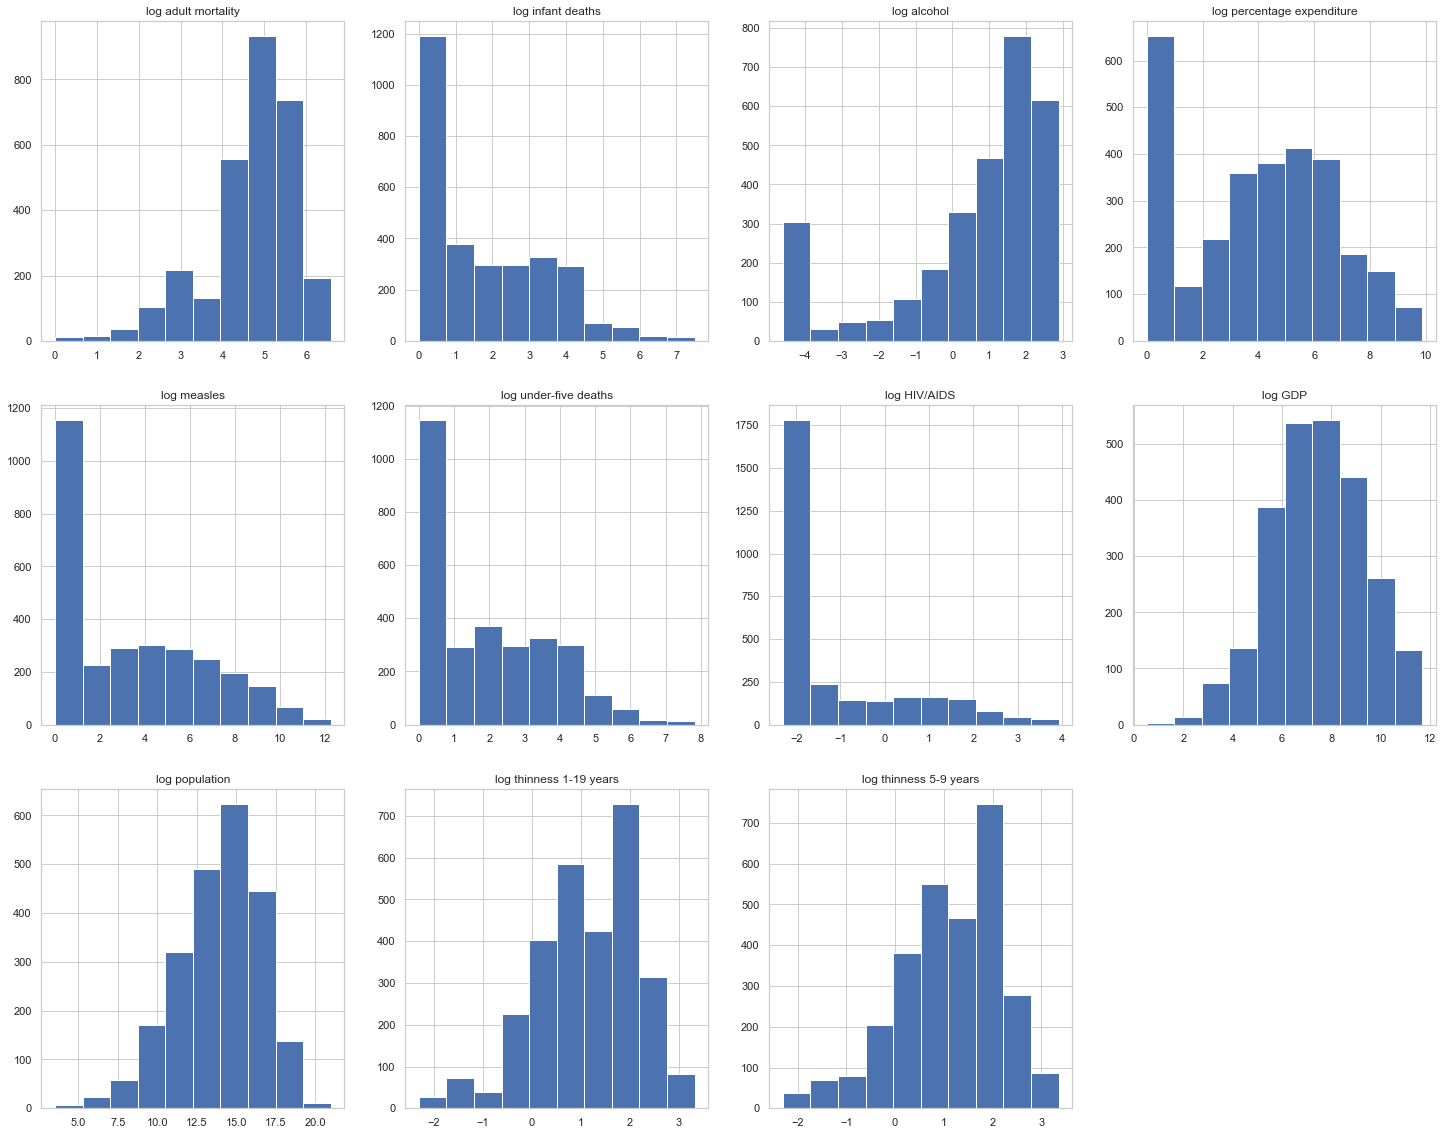

In [10]:
plt.figure(figsize=(25,20))

plt.subplot(3, 4, 1)
plt.hist(np.log(le2["Adult Mortality"]))
plt.title("log adult mortality")

plt.subplot(3, 4, 2)
plt.hist(np.log(le2["infant deaths"] + 1)) # add 1 because there are 0s in the set
plt.title("log infant deaths")

plt.subplot(3, 4, 3)
plt.hist(np.log(le2["Alcohol"]))
plt.title("log alcohol")

plt.subplot(3, 4, 4)
plt.hist(np.log(le2["percentage expenditure"] + 1))
plt.title("log percentage expenditure")

plt.subplot(3, 4, 5)
plt.hist(np.log(le2["Measles "] + 1))
plt.title("log measles")

plt.subplot(3, 4, 6)
plt.hist(np.log(le2["under-five deaths "] + 1))
plt.title("log under-five deaths")

plt.subplot(3, 4, 7)
plt.hist(np.log(le2[" HIV/AIDS"]))
plt.title("log HIV/AIDS")

plt.subplot(3, 4, 8)
plt.hist(np.log(le2["GDP"]))
plt.title("log GDP")

plt.subplot(3, 4, 9)
plt.hist(np.log(le2["Population"]))
plt.title("log population")

plt.subplot(3, 4, 10)
plt.hist(np.log(le2[" thinness  1-19 years"]))
plt.title("log thinness 1-19 years")

plt.subplot(3, 4, 11)
plt.hist(np.log(le2[" thinness 5-9 years"]))
plt.title("log thinness 5-9 years")

plt.show()

In [11]:
# create dataframe with modified data
le3 = pd.DataFrame()

le3['Country'] = le2['Country']
le3['Year'] = le2['Year']
le3['Status'] = le2['Status']
le3['Life expectancy'] = le2["Life expectancy "]
le3['log adult mortality'] = np.log(le2["Adult Mortality"])
le3['log infant deaths'] = np.log(le2["infant deaths"] + 1)
le3['log alcohol'] = np.log(le2["Alcohol"])
le3['log percentage expenditure'] = np.log(le2["percentage expenditure"] + 1)
le3['Hepatitis B'] = le2["Hepatitis B"]
le3['log measles'] = np.log(le2["Measles "] + 1)
le3['BMI'] = le2[" BMI "]
le3['log under-5 deaths'] = np.log(le2["under-five deaths "] + 1)
le3['Polio'] = le2["Polio"]
le3['Total expenditure'] = le2["Total expenditure"]
le3['Diphtheria'] = le2["Diphtheria "]
le3['log HIV/AIDS'] = np.log(le2[" HIV/AIDS"])
le3['log GDP'] = np.log(le2["GDP"])
le3['log population'] = np.log(le2["Population"])
le3['log thinness 1-19'] = np.log(le2[" thinness  1-19 years"])
le3['log thinness 5-9'] = np.log(le2[" thinness 5-9 years"])
le3['Income composition of resources'] = le2["Income composition of resources"]
le3['Schooling'] = le2["Schooling"]

In [12]:
le3.describe(include = 'all')

,Country,Year,Status,Life expectancy,log adult mortality,log infant deaths,log alcohol,log percentage expenditure,Hepatitis B,log measles,...,Polio,Total expenditure,Diphtheria,log HIV/AIDS,log GDP,log population,log thinness 1-19,log thinness 5-9,Income composition of resources,Schooling
count,2938,2938.000000,2938,2928.000000,2928.000000,2938.000000,2921.000000,2938.000000,2794.000000,2938.000000,...,2938.000000,2906.000000,2938.000000,2938.000000,2533.000000,2290.000000,2904.000000,2904.000000,2771.000000,2775.000000
unique,193,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Brazil,NaN,Developing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,16,NaN,2426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.518720,NaN,69.224932,4.707885,1.768585,0.511082,3.986284,78.648111,3.357053,...,82.396266,5.920966,82.183944,-1.221949,7.453883,13.893933,1.129200,1.117278,0.627551,11.992793
std,NaN,4.613841,NaN,9.523867,1.073931,1.663020,2.137816,2.729832,25.183816,3.259046,...,23.476067,2.469245,23.743205,1.613377,1.868886,2.658169,1.043545,1.076890,0.210904,3.358920
min,NaN,2000.000000,NaN,36.300000,0.000000,0.000000,-4.605170,0.000000,1.000000,0.000000,...,3.000000,0.370000,2.000000,-2.302585,0.519597,3.526361,-2.302585,-2.302585,0.000000,0.000000
25%,NaN,2004.000000,NaN,63.100000,4.304065,0.000000,-0.094311,1.737885,72.000000,0.000000,...,78.000000,4.260000,78.000000,-2.302585,6.129684,12.188760,0.470004,0.405465,0.493000,10.100000
50%,NaN,2008.000000,NaN,72.100000,4.969813,1.386294,1.316408,4.188334,89.000000,2.890372,...,93.000000,5.745333,93.000000,-2.302585,7.454092,14.149174,1.193922,1.193922,0.677000,12.300000
75%,NaN,2012.000000,NaN,75.700000,5.429346,3.135494,2.041220,6.092517,96.000000,5.889564,...,97.000000,7.440000,97.000000,-0.223144,8.670557,15.818013,1.974081,1.974081,0.779000,14.300000


In [13]:
# make correlation matrix
le3.corr()

,Year,Life expectancy,log adult mortality,log infant deaths,log alcohol,log percentage expenditure,Hepatitis B,log measles,BMI,log under-5 deaths,Polio,Total expenditure,Diphtheria,log HIV/AIDS,log GDP,log population,log thinness 1-19,log thinness 5-9,Income composition of resources,Schooling
Year,1.000000,0.170033,-0.027719,-0.052375,-0.175455,-0.068811,0.142231,-0.109825,0.108974,-0.054389,0.097369,0.082162,0.136900,-0.095239,0.167602,0.049031,-0.036747,-0.037571,0.243468,0.209400
Life expectancy,0.170033,1.000000,-0.447733,-0.592200,0.270787,0.374278,0.313494,-0.324932,0.567694,-0.621412,0.471485,0.229312,0.484676,-0.813386,0.599153,-0.112191,-0.530363,-0.535518,0.724776,0.751975
log adult mortality,-0.027719,-0.447733,1.000000,0.271656,-0.117537,-0.223516,-0.092141,0.108616,-0.285622,0.285238,-0.194357,-0.130017,-0.190392,0.380498,-0.284953,0.077384,0.257775,0.270063,-0.322923,-0.331473
log infant deaths,-0.052375,-0.592200,0.271656,1.000000,-0.288289,-0.332905,-0.279862,0.623712,-0.481264,0.996315,-0.365145,-0.201507,-0.346600,0.436404,-0.482937,0.443449,0.458844,0.467353,-0.435187,-0.546963
log alcohol,-0.175455,0.270787,-0.117537,-0.288289,1.000000,0.186665,0.063906,-0.179398,0.222783,-0.292089,0.171045,0.242132,0.149707,-0.052296,0.294008,-0.028402,-0.330577,-0.328881,0.286651,0.377168
log percentage expenditure,-0.068811,0.374278,-0.223516,-0.332905,0.186665,1.000000,0.075209,-0.148144,0.254174,-0.338056,0.173928,0.113009,0.183331,-0.200495,0.742533,-0.064573,-0.270869,-0.273899,0.391572,0.421915
Hepatitis B,0.142231,0.313494,-0.092141,-0.279862,0.063906,0.075209,1.000000,-0.212957,0.189323,-0.285409,0.506397,0.101272,0.603564,-0.278480,0.158737,-0.070329,-0.051354,-0.054662,0.232086,0.285957
log measles,-0.109825,-0.324932,0.108616,0.623712,-0.179398,-0.148144,-0.212957,1.000000,-0.319396,0.623848,-0.242027,-0.160414,-0.243351,0.232129,-0.221711,0.280380,0.310172,0.313110,-0.197736,-0.283646
BMI,0.108974,0.567694,-0.285622,-0.481264,0.222783,0.254174,0.189323,-0.319396,1.000000,-0.498010,0.285017,0.243629,0.283578,-0.486625,0.450793,-0.073952,-0.549634,-0.557345,0.508774,0.546961
log under-5 deaths,-0.054389,-0.621412,0.285238,0.996315,-0.292089,-0.338056,-0.285409,0.623848,-0.498010,1.000000,-0.377223,-0.205412,-0.359788,0.470358,-0.495585,0.438522,0.468498,0.476193,-0.454658,-0.567293


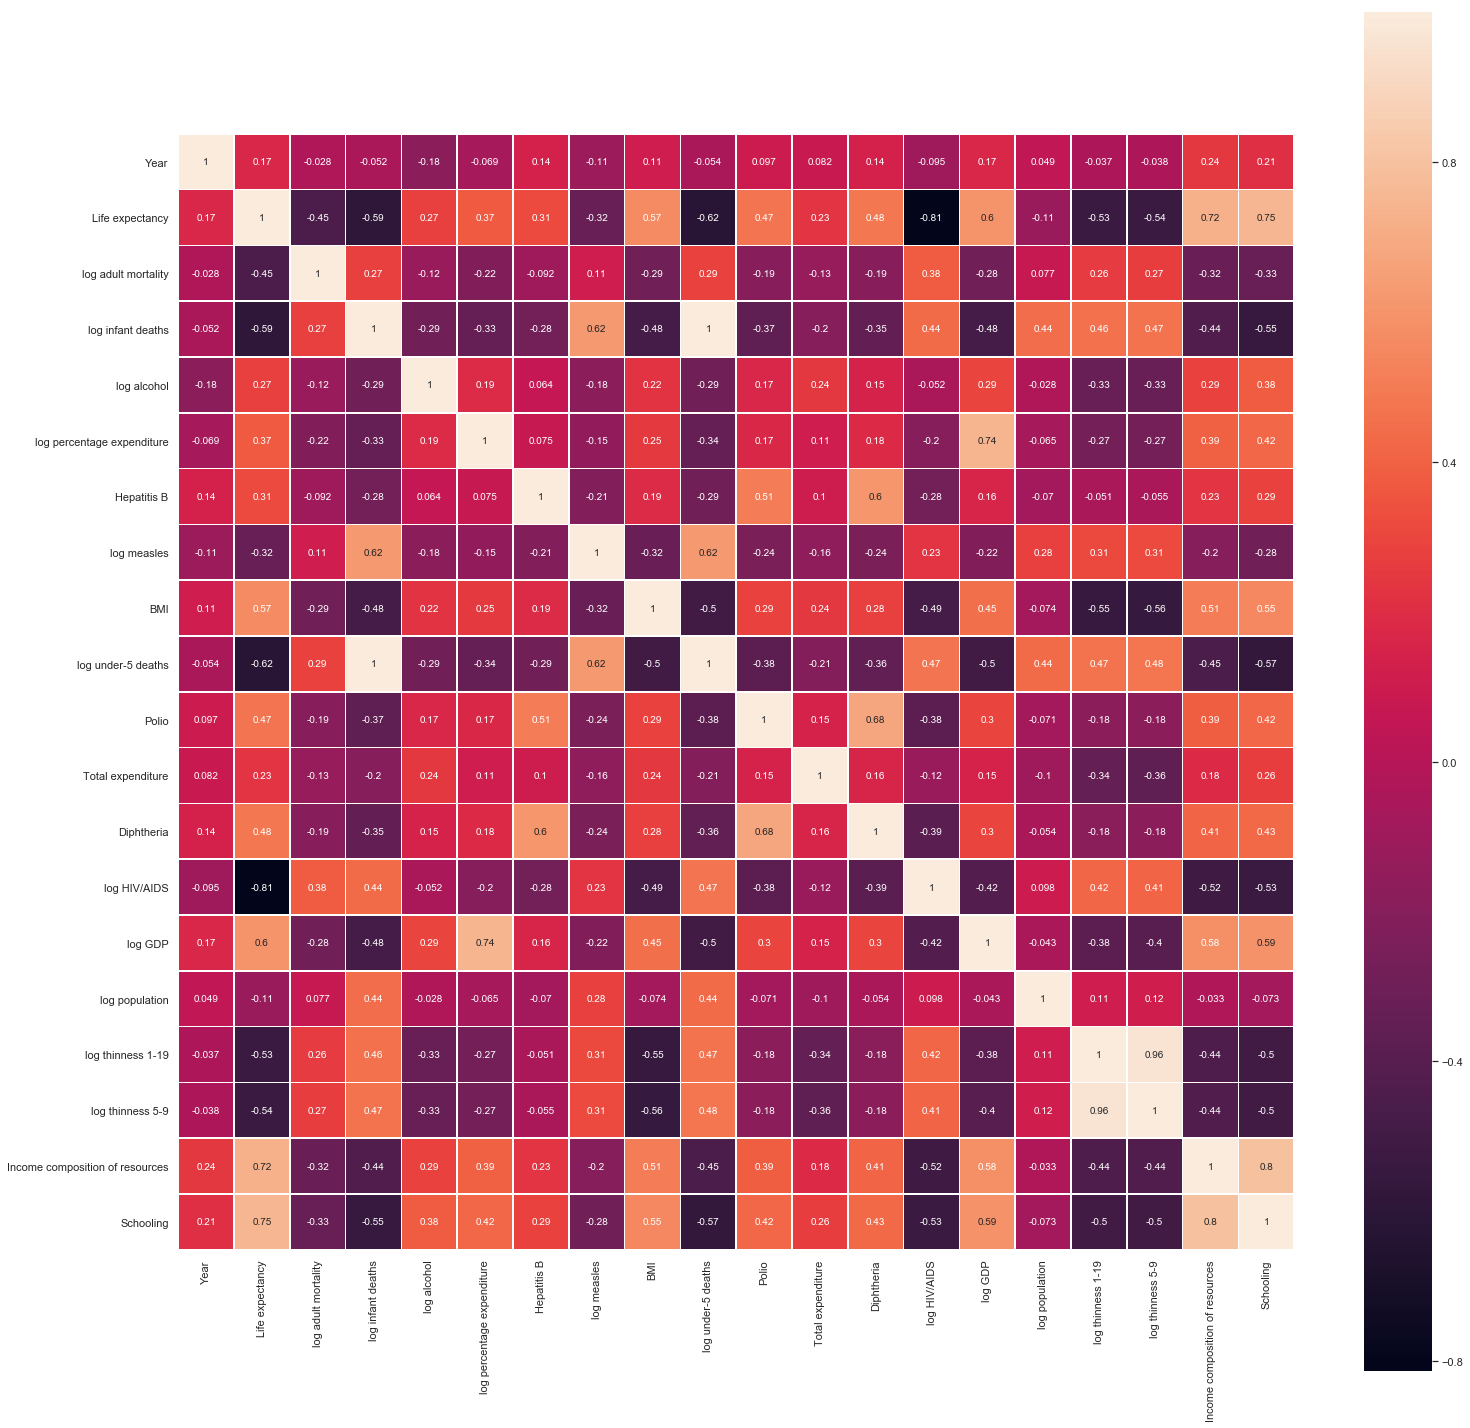

In [14]:
# plot the correlation matrix

plt.figure(figsize = (25,25))
sns.heatmap(le3.corr(), square=True, annot=True, linewidths=.5)
plt.show()

In [15]:
# drop string data for PCA usage
le3.drop("Country", axis=1, inplace=True)
le3.drop("Status", axis=1, inplace=True)

In [16]:
# standardize data...will this work with so many zeroes?
X = StandardScaler().fit_transform(le3)

In [17]:
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[ 1.00034048         nan         nan -0.05239318         nan -0.06883472
          nan -0.10986273         nan -0.05440795  0.09740251         nan
   0.13694689 -0.09527181         nan         nan         nan         nan
          nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan]
 [-0.05239318         nan         nan  1.00034048         nan -0.33301819
          nan  0.62392424         nan  0.99665384 -0.36526973         nan
  -0.34671826  0.43655249         nan         nan         nan         nan
          n